In [54]:
# Copyright (c) Microsoft Corporation.
# Licensed under the MIT License.

"""Tabular Q-learning agent (notebook)

This notebooks can be run directly from VSCode, to generate a
traditional Jupyter Notebook to open in your browser
 you can run the VSCode command `Export Currenty Python File As Jupyter Notebook`.
"""

# pylint: disable=invalid-name

'Tabular Q-learning agent (notebook)\n\nThis notebooks can be run directly from VSCode, to generate a\ntraditional Jupyter Notebook to open in your browser\n you can run the VSCode command `Export Currenty Python File As Jupyter Notebook`.\n'

In [55]:
%load_ext autoreload
%autoreload 1

In [56]:
import sys
import datetime
import os
import logging
from typing import cast
import gym
import numpy as np
import matplotlib.pyplot as plt  # type:ignore

from dotenv import load_dotenv, dotenv_values
load_dotenv()

import re

In [4]:
from cyberbattle.agents.baseline.learner import TrainedLearner
import cyberbattle.agents.baseline.plotting as p
import cyberbattle.agents.baseline.agent_wrapper as w
import cyberbattle.agents.baseline.agent_tabularqlearning as a
from cyberbattle.agents.baseline.agent_wrapper import Verbosity
import cyberbattle.agents.baseline.learner as learner
from cyberbattle._env.cyberbattle_env import AttackerGoal

from cyberbattle.simulation.config import configuration, logger
#logging.basicConfig(stream=sys.stdout, level=logging.ERROR, format="%(levelname)s: %(message)s")

INFO:General:Enter exploration phase instead of exploitation                   |done_at: --|loss: ----|epsilon:   0.9|best_eval_mean: -1.79769e+308|Elapsed Time: 0:00:00|||
INFO:General:Choose exploration phase                                          |done_at: --|loss: ----|epsilon:   0.9|best_eval_mean: -1.79769e+308|Elapsed Time: 0:00:00|||
INFO:General:Choose exploration phase                                          |done_at: --|loss: ----|epsilon:   0.9|best_eval_mean: -1.79769e+308|Elapsed Time: 0:00:00|||
INFO:General:GOT REWARD r=14.0 with 	Action: GET_/v2/login/ScanLoginPage	Profile: username.NoAuth,	Precondition: username.NoAuth	 Description: Discovered login form linked to endopoint POST /v2/login & rules for correct username/password, ex. pattern for username
INFO:General:discovered node: POST_/v2/login
INFO:General:Choose exploration phase                                          |done_at: --|loss: ----|epsilon:   0.9|best_eval_mean: -1.79769e+308|Elapsed Time: 0:00:00|||

In [5]:
def strip_symbols(string):
    return re.sub(r'[^a-zA-Z0-9]', '', string)

In [52]:
# Benchmark parameters:
#   Parameters from DeepDoubleQ paper
#    - learning_rate = 0.00025
#    - linear epsilon decay
#    - gamma = 0.99
#   Eliminated gamma_values
#       0.0,
#       0.0015,  # too small
#       0.15,  # too big
#       0.25,  # too big
#       0.35,  # too big
#
# NOTE: Given the relatively low number of training episodes (50,
# a high learning rate of .99 gives better result
# than a lower learning rate of 0.25 (i.e. maximal rewards reached faster on average).
# Ideally we should decay the learning rate just like gamma and train over a
# much larger number of episodes

gymid = 'CyberBattleTinyMicro-v1234'
# cyberbattlechain_10 = gym.make('CyberBattleChain-v0', size=10, attacker_goal=AttackerGoal(own_atleast_percent=1.0))
cyberbattlechain_10 = gym.make(gymid)  # , attacker_goal=AttackerGoal(own_atleast_percent=1.0))


ep = w.EnvironmentBounds.of_identifiers(
    maximum_node_count=12,
    maximum_total_credentials=1,
    identifiers=cyberbattlechain_10.identifiers
)

iteration_count = 50
training_episode_count = 4000
eval_episode_count = 10
gamma_sweep = [
    0.9,  # about right
    0.5,
    0.25,
    0.15,
    0.015
]
gamma_sweep = sorted(gamma_sweep)
eval_freq = 50
mean_reward_window = 3
seed = 0
epsilon_exponential_decay = int(os.getenv('EPS_EXP_DECAY', 2000))  # 5000
epsilon_minimum = 0.10

def qlearning_run(gamma = 0.015, gym_env = cyberbattlechain_10, learning_rate=0.9):
    """Execute one run of the q-learning algorithm for the
    specified gamma value"""
    
    log_results = True
    log_level = 'info'
    log_dir = '/logs/exper/' + "notebook_dql_debug_with_tinymicro"
    log_dir = os.path.join(log_dir, 'qtabular')
    # convert the datetime object to string of specific format
    datetime_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    log_dir = os.path.join(log_dir, gymid, datetime_str)
    os.environ['LOG_DIR'] = log_dir

    os.makedirs(log_dir, exist_ok=True) if log_results else ''
    configuration.update_globals(log_dir, gymid, log_level, log_results)
    configuration.update_logger()
    return learner.epsilon_greedy_search(
        gym_env,
        ep,
        a.QTabularLearner(ep, gamma=gamma, learning_rate=learning_rate, exploit_percentile=100),
        episode_count=training_episode_count,
        iteration_count=iteration_count,
        epsilon=0.90,
        render=False,
        #epsilon_multdecay=0.75,  # 0.999,
        epsilon_exponential_decay=epsilon_exponential_decay,
        epsilon_minimum=epsilon_minimum,
        eval_episode_count = eval_episode_count,
        eval_freq=eval_freq,
        mean_reward_window=mean_reward_window,
        seed=seed,
        verbosity=Verbosity.Quiet,
        title="Q-learning"
    )
    if configuration.log_results:
        configuration.writer.close()

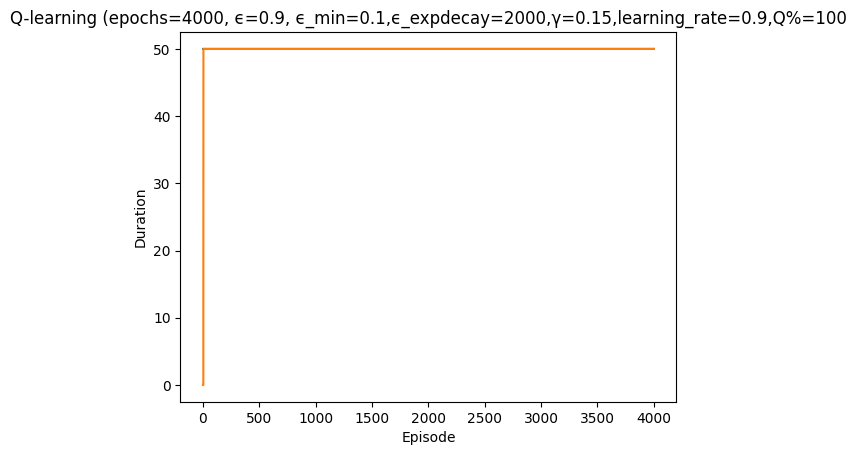

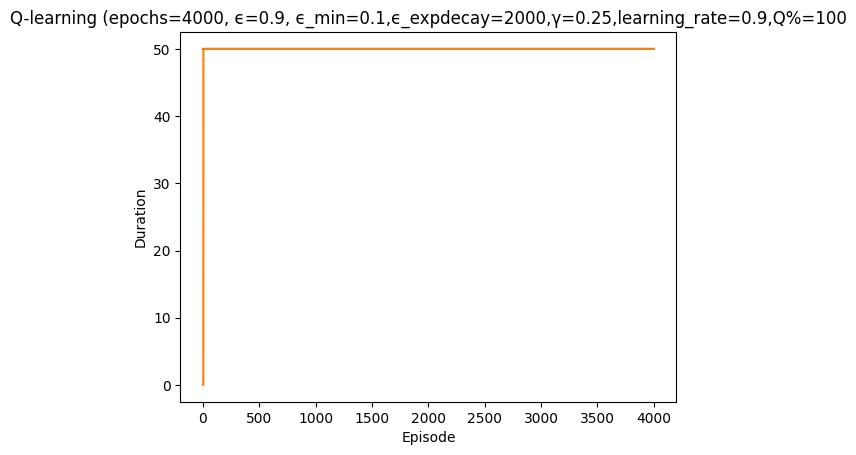

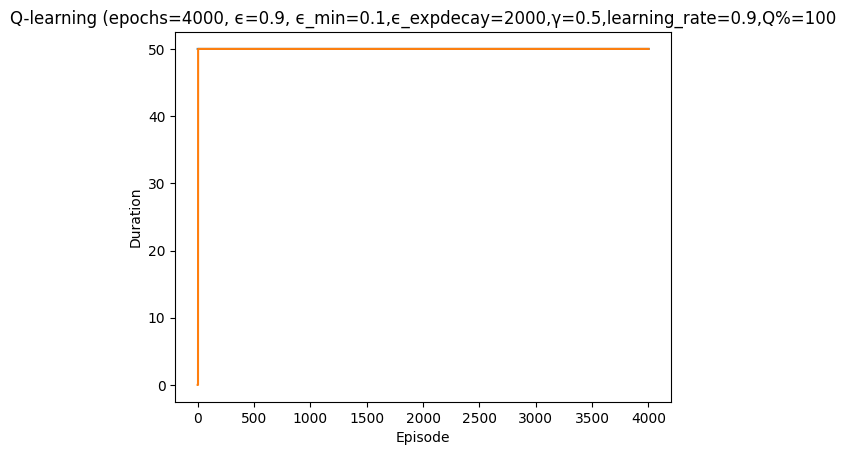

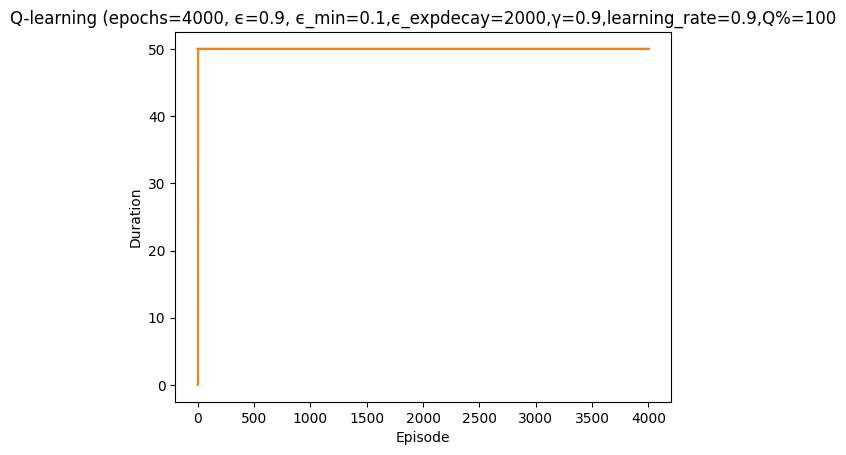

In [53]:
# Run Q-learning with gamma-sweep
qlearning_results = [qlearning_run(gamma, cyberbattlechain_10) for gamma in gamma_sweep]

qlearning_bestrun_10 = qlearning_results[0]

-832.6666666666666

-832.3333333333334

-819.0

-834.0

-818.6666666666666

-907.0

-897.3333333333334

-901.6666666666666

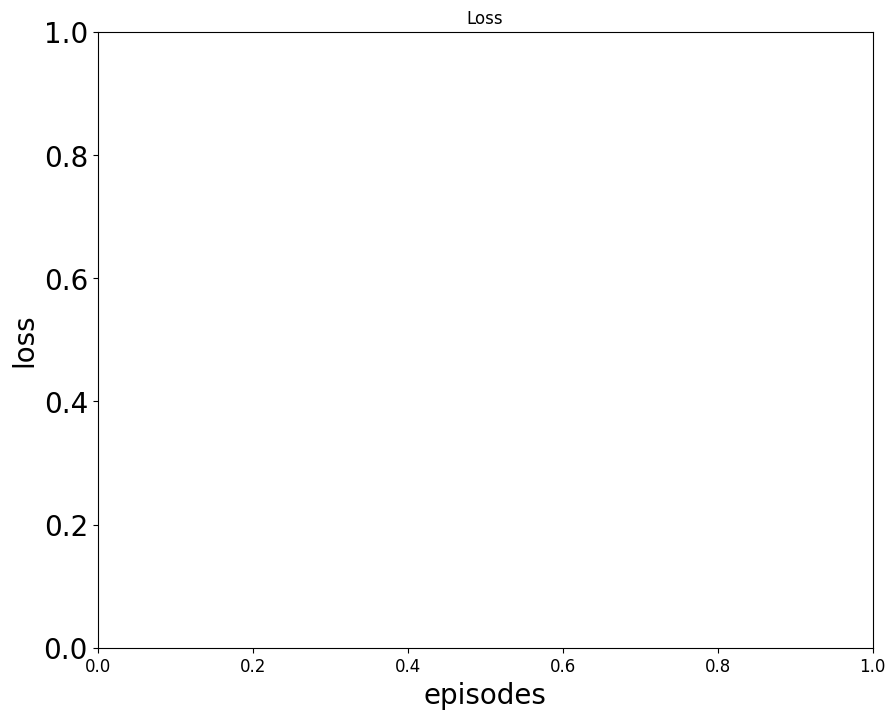

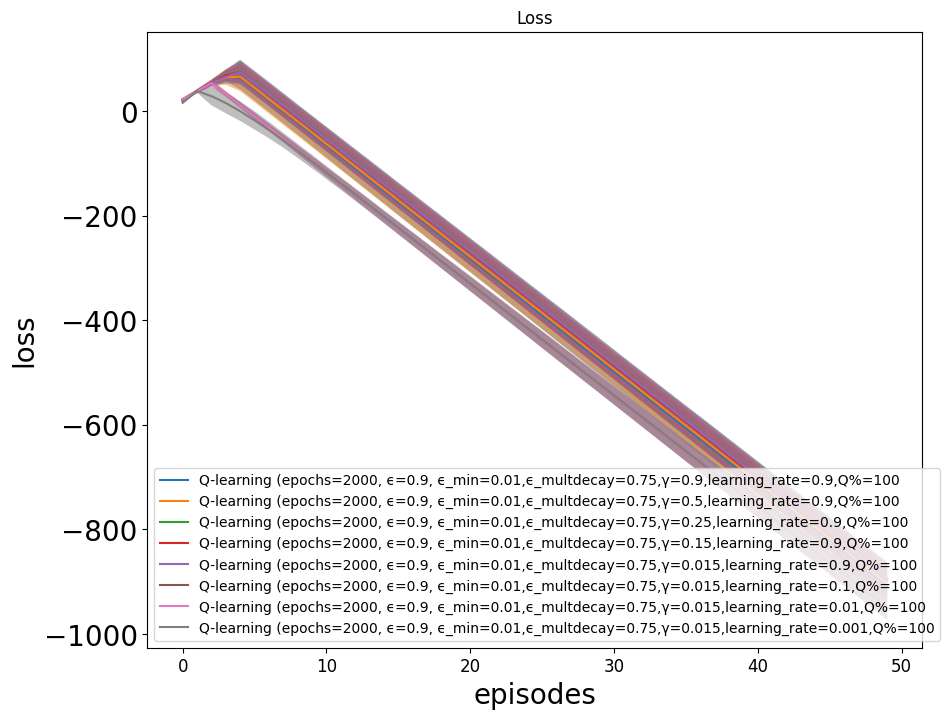

In [48]:
p.new_plot_loss()
for results in qlearning_results:
    display(results['best_running_mean'])
    p.plot_episodes_rewards_averaged(results)
plt.legend()
plt.show()

In [19]:

p.new_plot_loss()
for results in qlearning_results:
    p.plot_all_episodes_loss(cast(a.QTabularLearner, results['learner']).loss_qsource.all_episodes, 'Q_source', results['title'])
    p.plot_all_episodes_loss(cast(a.QTabularLearner, results['learner']).loss_qattack.all_episodes, 'Q_attack', results['title'])
    #plt.legend(loc="upper right")
plt.show()

TypeError: 'QTabularLearner' object is not subscriptable

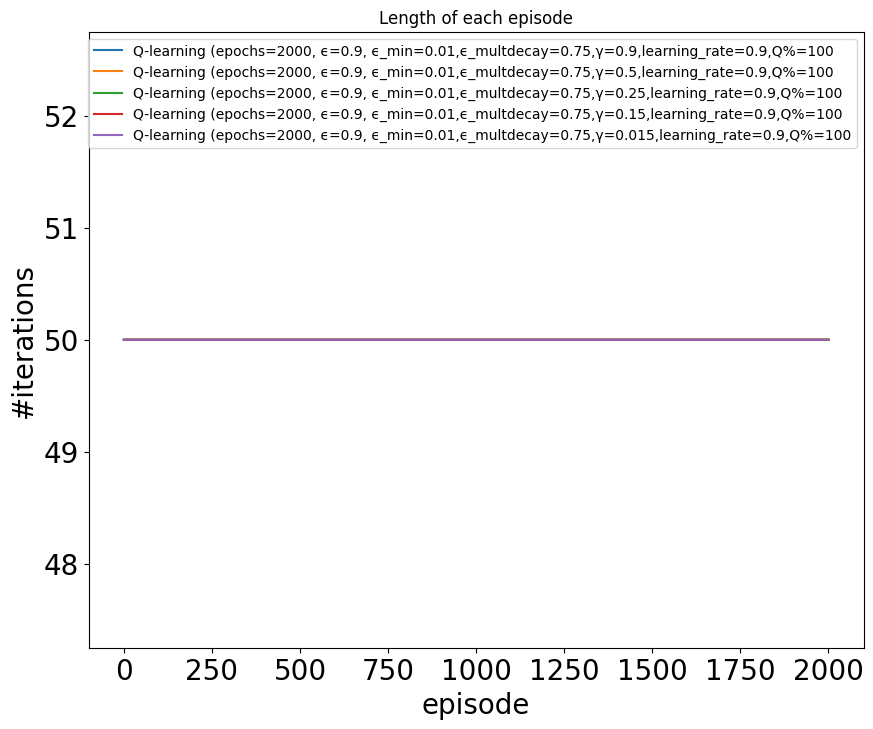

In [15]:

p.plot_episodes_length(qlearning_results)

In [ ]:


nolearning_results = learner.epsilon_greedy_search(
    cyberbattlechain_10,
    ep,
    learner=a.QTabularLearner(ep, trained=qlearning_bestrun_10['learner'],
                              gamma=0.0, learning_rate=0.0, exploit_percentile=100),
    episode_count=eval_episode_count,
    iteration_count=iteration_count,
    epsilon=0.30,  # 0.35,
    render=False,
    title="Exploiting Q-matrix",
    verbosity=Verbosity.Quiet
)

In [ ]:
randomlearning_results = learner.epsilon_greedy_search(
    cyberbattlechain_10,
    ep,
    learner=a.QTabularLearner(ep, trained=qlearning_bestrun_10['learner'],
                              gamma=0.0, learning_rate=0.0, exploit_percentile=100),
    episode_count=eval_episode_count,
    iteration_count=iteration_count,
    epsilon=1.0,  # purely random
    render=False,
    verbosity=Verbosity.Quiet,
    title="Random search"
)

In [ ]:
# Plot averaged cumulative rewards for Q-learning vs Random vs Q-Exploit
all_runs = [*qlearning_results,
            randomlearning_results,
            nolearning_results
            ]

Q_source_10 = cast(a.QTabularLearner, qlearning_bestrun_10['learner']).qsource
Q_attack_10 = cast(a.QTabularLearner, qlearning_bestrun_10['learner']).qattack

p.plot_averaged_cummulative_rewards(
    all_runs=all_runs,
    title=f'Benchmark -- max_nodes={ep.maximum_node_count}, episodes={eval_episode_count},\n'
    f'dimension={Q_source_10.state_space.flat_size()}x{Q_source_10.action_space.flat_size()}, '
    f'{Q_attack_10.state_space.flat_size()}x{Q_attack_10.action_space.flat_size()}\n'
    f'Q1={[f.name() for f in Q_source_10.state_space.feature_selection]} '
    f'-> {[f.name() for f in Q_source_10.action_space.feature_selection]})\n'
    f"Q2={[f.name() for f in Q_attack_10.state_space.feature_selection]} -> 'action'")

In [ ]:
# plot cumulative rewards for all episodes
p.plot_all_episodes(qlearning_results[0])

In [ ]:
# Plot the Q-matrices

In [ ]:
# Print non-zero coordinate in the Q matrix Q_source
i = np.where(Q_source_10.qm)
q = Q_source_10.qm[i]
list(zip(np.array([Q_source_10.state_space.pretty_print(i) for i in i[0]]),
         np.array([Q_source_10.action_space.pretty_print(i) for i in i[1]]), q))

In [ ]:
# Print non-zero coordinate in the Q matrix Q_attack
i2 = np.where(Q_attack_10.qm)
q2 = Q_attack_10.qm[i2]
list(zip([Q_attack_10.state_space.pretty_print(i) for i in i2[0]],
         [Q_attack_10.action_space.pretty_print(i) for i in i2[1]], q2))


##################################################

## Transfer learning from size 4 to size 10
Exploiting Q-matrix learned from a different network.

In [ ]:
# Train Q-matrix on CyberBattle network of size 4
cyberbattlechain_4 = gym.make('CyberBattleTinyMicro-v12')  # , size=4,
# attacker_goal=AttackerGoal(own_atleast_percent=1.0)
# )

qlearning_bestrun_4 = qlearning_run(0.015, gym_env=cyberbattlechain_4)


def stop_learning(trained_learner):
    return TrainedLearner(
        learner=a.QTabularLearner(
            ep,
            gamma=0.0,
            learning_rate=0.0,
            exploit_percentile=0,
            trained=trained_learner['learner']
        ),
        title=trained_learner['title'],
        trained_on=trained_learner['trained_on'],
        all_episodes_rewards=trained_learner['all_episodes_rewards'],
        all_episodes_availability=trained_learner['all_episodes_availability']
    )


# learner.transfer_learning_evaluation(
#     environment_properties=ep,
#     trained_learner=stop_learning(qlearning_bestrun_4),
#     eval_env=cyberbattlechain_10,
#     eval_epsilon=0.5,  # alternate with exploration to help generalization to bigger network
#     eval_episode_count=eval_episode_count,
#     iteration_count=iteration_count
# )

learner.transfer_learning_evaluation(
    environment_properties=ep,
    trained_learner=stop_learning(qlearning_bestrun_10),
    eval_env=cyberbattlechain_4,
    eval_epsilon=0.5,
    eval_episode_count=eval_episode_count,
    iteration_count=iteration_count
)